In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.figsize'] = (18,6)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

In [74]:
#Historcal Data from Kaggle
playerGameData = pd.read_csv("playerGameData.csv")

playerGameData['CalculatedFPPG'] =  playerGameData['PTS'] + 1.2 * playerGameData['REB']\
    + 1.5 * playerGameData['AST'] + 3 * playerGameData['STL'] + 3 * playerGameData['BLK'] - playerGameData['TO']

C:\Users\stvp2\AppData\Local\Temp\ipykernel_35428\2009563491.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  playerGameData = pd.read_csv("playerGameData.csv")


In [75]:
#All available playoff data for teams: Miami Heat, NY knicks, Golden State Warriors, LA Lakers
Playoff_Data = pd.read_csv("playoffData.csv")

Playoff_Data['CalculatedFPPG'] =  Playoff_Data['PTS'] + 1.2 * Playoff_Data['REB']\
    + 1.5 * Playoff_Data['AST'] + 3 * Playoff_Data['STL'] + 3 * Playoff_Data['BLK'] - Playoff_Data['TO']

In [ ]:
player_info = {} #create dictionary of players in playoffs
player_names = playerGameData['PLAYER_NAME'].unique() # Line-up of all player data in NBA since 2004

for player_name in player_names:
    player_df = playerGameData[playerGameData["PLAYER_NAME"] == player_name] #create new dataframe based on every unique name in playerGameData
    player_df = player_df.dropna(subset=['CalculatedFPPG']) #removes rows when the player did not play
    FPPG = np.flip(player_df['CalculatedFPPG'].to_numpy()) #makes a vector of caluclated FPPG in reverse order(earliest to most recent FPPG)
    window_size = 7 #creating a window of most recent seven games
    num_games = len(FPPG)
    if num_games < 40: #excludes players with fewer than 40 games played
        continue
    num_train_games = int(num_games * 0.8) #create a training split of 80% of the data
    num_test_games = num_games - num_train_games #create a testing split of 20% of the data
    num_train_windows = num_train_games - window_size + 1 #creates the correct number of training windows to slide through based on individual players
    num_test_windows = num_test_games - window_size #creates the correct number of testing windows to slide through based on individual players 
    z = np.zeros((num_train_windows, window_size)) #initialize player training matrix
    for i in range(num_train_windows):
        z[i, :] = FPPG[i:(i + window_size)]

    ###This creates a test matrix for cases in predicting any window of time 
    ###This validates that our gaussian process is working
    z_test = np.zeros((num_test_windows, window_size)) #initialize player training matrix
    for i in range(num_test_windows):
        start_idx = num_train_games + 1 + i 
        end_idx = start_idx + window_size
        window_values = FPPG[start_idx:end_idx]
        if len(window_values) < window_size:
            # Fill missing values with player's average FPPG
            avg_FPPG = player_df['CalculatedFPPG'].mean()
            num_missing_values = window_size - len(window_values)
            missing_values = np.ones(num_missing_values) * avg_FPPG
            window_values = np.concatenate([window_values, missing_values])
        z_test[i, :] = window_values
    
    
    m = np.mean(z, axis=0) #calculates the mean vector for each player training-window, column-wise. 
    z_demean = z - m #mean-centering the training matrix

    cov_matrix = np.zeros((window_size, window_size))# initialize the covariance matrix
    for r in range(0,num_train_windows):
        cov_matrix = cov_matrix + np.matmul(z_demean[r:(r+1),:].T, z_demean[r:(r+1),:]) 
    cov_matrix = cov_matrix/num_train_windows

    m_x = m[0:6] #average six-day history
    m_y = m[6:7] #average 7th-data history
    Caa = cov_matrix[0:6,0:6] #covariance between the first six games
    Cab = cov_matrix[0:6,6:7] #covariance between the first six games and the seventh game 
    Cba = cov_matrix[6:7,0:6] #covariance between the seventh game and the first six games
    Cbb = cov_matrix[6:7,6:7] #variance of the seventh game

    CaaInv = np.linalg.inv(Caa) #inverse of the covariance of the first six games

    ###define function to predict the seventh day
    def pred(xa,m_x,m_y,Cba,CaaInv):
        return m_y + np.matmul(np.matmul(Cba,CaaInv),xa-m_x)
    
    
    pred_sigma = np.sqrt(Cbb - np.matmul(np.matmul(Cba, CaaInv), Cab))[0] #calucate the predicted standard deviation
    
     ###This creates a test matrix for the playoff games                                                                   
    if player_name in Playoff_Data['PLAYER'].unique():
        playoff_vector = Playoff_Data.loc[Playoff_Data['PLAYER'] == player_name, 'CalculatedFPPG'].values
        playoff_t = playoff_vector[:-1]
        if len(playoff_t) < window_size:
            # Fill missing values with player's average FPPG
            avg_FPPG_playoff = playoff_t.mean()
            num_missing_values = window_size - len(playoff_t)
            missing_values = np.ones(num_missing_values) * avg_FPPG_playoff
            playoff_t = np.concatenate([playoff_t, missing_values])
        Y_pred = pred(playoff_t[-6:],m_x,m_y,Cba,CaaInv) #predict the seventh day based on the six most recent game
        FPPG_actual = playoff_vector[-1]


            
        errors = FPPG_actual - Y_pred
        
        predRMSE = np.sqrt(np.mean(np.square(errors))) 
            
        player_info[player_name] = {'player_name': player_name, 
                            'pred_sigma': pred_sigma, 
                            'sigma': np.std(errors), 
                            'mx':m_x, 
                            'my':m_y,
                            'Caa': Caa,
                            'Cab':Cab,
                            'Cba':Cba,
                            'Cbb':Cbb,
                            'Y_pred':Y_pred,
                            'FPPG_actual': FPPG_actual,
                            'playoff_t': playoff_t[-6:],
                            'playoff_vector':playoff_vector,
                            'RMSE': predRMSE
                            }

In [ ]:
from pandas import json_normalize

player_info_df = pd.DataFrame(player_info).T
player_info_df1 = player_info_df.set_index('player_name')
player_info_df1 = player_info_df[["pred_sigma","Y_pred"]]
player_info_df1['Y_pred'] = player_info_df1['Y_pred'].apply(lambda x: x[0])
#player_info_df1.to_csv("player_historical_info.csv")

c:\Users\stvp2\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


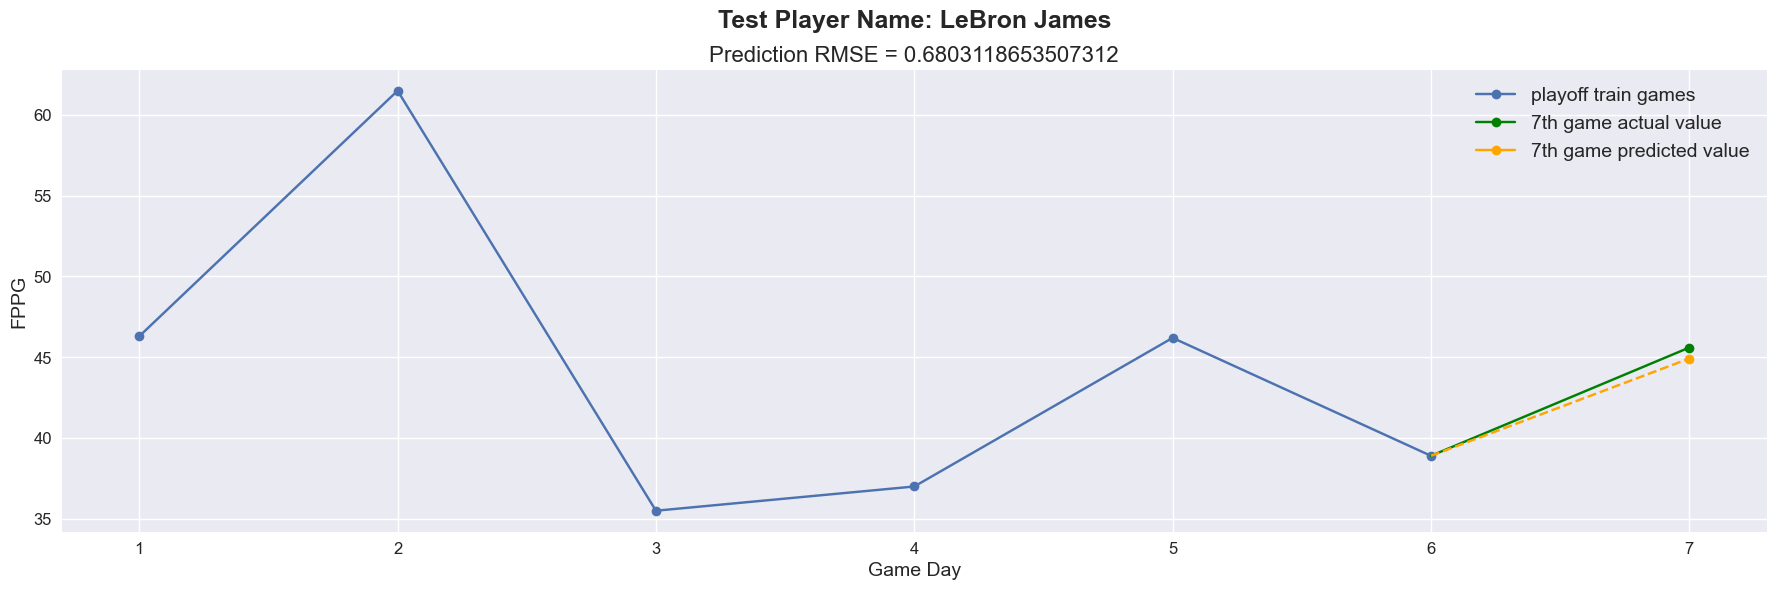

In [78]:
plt.figure(figsize=(22,6))
plt.plot(np.arange(0,6),player_info['LeBron James']['playoff_t'], marker='o', label = str("playoff train games"));
plt.plot(np.arange(6,7),player_info['LeBron James']['FPPG_actual'], marker='o', color='g', label=str("7th game actual value")); # actual value for game we are predicting
plt.plot(np.arange(5,7),player_info['LeBron James']['playoff_vector'][7:9], color='g')
plt.plot(np.arange(5,7),[player_info['LeBron James']['playoff_vector'][7], player_info['LeBron James']['Y_pred']], linestyle='dashed', color='orange') #, label='y_pred'+str(playoff_vector[-6:]));
plt.plot(np.arange(6,7),player_info['LeBron James']['Y_pred'], marker='o', color='orange', label=str("7th game predicted value"));
plt.suptitle('        Test Player Name: ' + str(player_info["LeBron James"]['player_name']), fontsize=18, fontweight='bold')
plt.title('Prediction RMSE = '+ str(player_info["LeBron James"]['RMSE']), fontsize=16, y=1)

plt.xticks(np.arange(7), np.arange(1, 8))
plt.xlabel('Game Day')
plt.ylabel('FPPG')
plt.legend(fontsize = 14);